In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import string
from collections import Counter
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

# Check the data

In [3]:
#twdata=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#testdata=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
twdata=pd.read_csv('train.csv')
testdata=pd.read_csv('test.csv')

In [4]:
twdata.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
testdata.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# check random sample to get some more understanding on the keyword & location
twdata.sample(n=5)

,id,keyword,location,text,target
6546,9367,survived,"Port Harcourt, Nigeria",Nigerian boxer ?who survived sessions with Kli...,0
385,558,arson,NaN,Los Angeles Times: Arson suspect linked to 30 ...,1
5542,7907,radiation%20emergency,NaN,Who Else Wants Documents Radiation Emergency P...,0
2062,2956,dead,NaN,i miss my longer hair..but it was so dead anyw...,0
2347,3377,demolition,NaN,@czallstarwes more like demolition derby ??,0


In [7]:
twdata.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
print('training data shape {}, test data shape {}'.format(twdata.shape,testdata.shape))

training data shape (7613, 5), test data shape (3263, 4)


# EDA

**'location' does not contain valid data and many places they are missing. So will drop this feature.**

Analyze the "keyword" feature

In [9]:
def plot_feature_col(data, col, comment):
    keyword_dist=data[col].value_counts()

    fig = plt.figure(figsize=(8, 3), dpi=100) # figsize-width,height

    keyword_dist[:40].plot.bar()

    plt.title(comment)
    plt.legend([col+' count'])
    plt.show()
    
    return keyword_dist

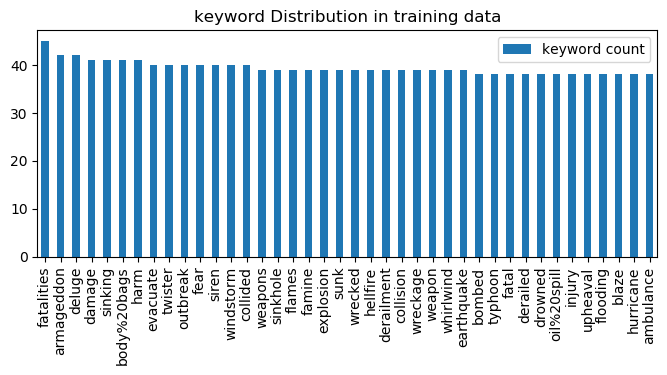

In [10]:
keyword_dist_training = plot_feature_col(twdata, 'keyword', 'keyword Distribution in training data')

In [11]:
keyword_dist_training[:100]

fatalities        45
armageddon        42
deluge            42
damage            41
sinking           41
                  ..
suicide%20bomb    35
flood             35
traumatised       35
collapsed         35
rescued           35
Name: keyword, Length: 100, dtype: int64

In [12]:
pd.options.display.max_colwidth = 200  # set a value as required for better visualization

twdata.sample(n=10)

,id,keyword,location,text,target
4910,6990,massacre,London,@MartynWaites It's a well-known fact that the St Valentine's Day massacre could have been avoided with some 'oompah-period' Tom Waits.,1
668,963,blaze,"Penn Hills, PA",I liked a @YouTube video http://t.co/N95IGskd3p Minecraft: Episode 2 'Blaze Farm Beginnings!',0
138,198,airplane%20accident,"Salt Lake City, Utah",@crobscarla your lifetime odds of dying from an airplane accident are 1 in 8015.,0
1128,1626,bombed,"Warwick, RI @Dollarocracy also",Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,1
5836,8339,rubble,"Dallas, Tejas",Photo: postapocalypticflimflam: Prodding around the rubble. http://t.co/Bgy4i47j70,0
3487,4984,explosion,"Chicago, IL",@AminESPN Mencius tears are worse correct? Takes the explosion n more pain day to day right?,0
1227,1768,buildings%20burning,New Hampshire,Witness video shows car explode behind burning buildings on 2nd St this afternoon #Manchester http://t.co/cgmJlSEYLo via @MikeCroninWMUR,1
1201,1727,buildings%20burning,"Madison, GA",@_minimehh @cjoyner I must be overlooking the burning buildings? #BlackLivesMatter,1
7168,10272,war%20zone,We're All Mad Here,Packing for CT aka my room looks like a war zone,0
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby County until 08:00 PM Wednesday. http://t.co/nZ7ACKRrJi #tnwx,1


**Check the test data keyword distribution**

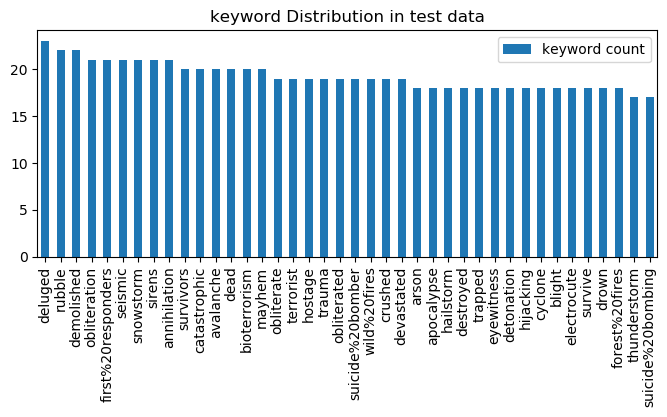

In [13]:
# check the keyword distribution using plot
keyword_dist_test = plot_feature_col(testdata, 'keyword', 'keyword Distribution in test data')

In [14]:
keyword_dist_test[:100]

deluged                23
rubble                 22
demolished             22
obliteration           21
first%20responders     21
                       ..
volcano                15
buildings%20burning    15
demolition             15
screams                15
hazardous              15
Name: keyword, Length: 100, dtype: int64

**From the above analysis its observed that most of the times keyword's are allready present in the text and some time not.**
**Also many keyword's are common in training & test data.**
**Will combine the keyword and text features for further analysis**

In [15]:
# for keyword fill the NaN values as NAN, will remove the same later
twdata['keyword'].fillna('NAN', inplace=True)
testdata['keyword'].fillna('NAN', inplace=True)

In [16]:
twdata['text']=twdata['text'] + " " + twdata['keyword']
testdata['text']=testdata['text'] + " " + testdata['keyword']

In [17]:
twdata.sample(5)

,id,keyword,location,text,target
5371,7663,panic,NaN,we was all just laughing and talking junk now everyone in panic mode panic,0
2579,3697,destroy,Nigeria,@elgeotaofeeq that's not my take from his piece. Not putting that ambition in check will destroy the change we voted for the change we seek destroy,0
890,1288,bloody,"England,UK,Europe,Sol 3.",@LauradeHolanda I have the Forrest version from '83 that's bloody awful as well :))) xxx bloody,0
1434,2069,casualty,"El Dorado, KS",@ThomasHCrown My grandfather was set to be in the first groups of Marines to hit Japan in Operation Olympic. 95% casualty rate predictions casualty,1
2325,3341,demolished,"Medford, Oregon",'Dangerous' property in downtown Phoenix demolished http://t.co/hiBDw7d7ja demolished,0


In [18]:
testdata.sample(5)

,id,keyword,location,text
1112,3673,destroy,NaN,But bad people kiss too. Hehe\nTheir kisses can destroy. destroy
879,2901,damage,Buzz City,@VZWSupport Zero damage just a horrible product damage
612,1998,bush%20fires,NaN,Bushfire causes first victim in Albania :: The multiple fires in Albania have caused the first vict http://t.co/yuba6XmBlq #Bush bush%20fires
2614,8730,sinking,"Washington, DC",Sinking. {part 2}\n??????\n#buildingmuseum #TheBEACHDC #VSCOcam #acreativedc #dc #dctography #vscodcÛ_ https://t.co/SsD9ign6HO sinking
1556,5239,fatality,Bobba Island,'come from south like ya name asher d' big h does come with some fatality bars in his minor lotm 'battle' fatality


In [19]:
# drop location & keyword column
twdata.drop(columns=['location','keyword'],axis=1, inplace=True)
testdata.drop(columns=['location','keyword'],axis=1, inplace=True)

In [20]:
# verify the final tables

In [21]:
twdata.head(2)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1
1,4,Forest fire near La Ronge Sask. Canada NAN,1


In [22]:
twdata.head(2)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all NAN,1
1,4,Forest fire near La Ronge Sask. Canada NAN,1


In [23]:
twdata.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [24]:
testdata.isnull().sum()

id      0
text    0
dtype: int64

**plot the 'target' to understand its distribution**

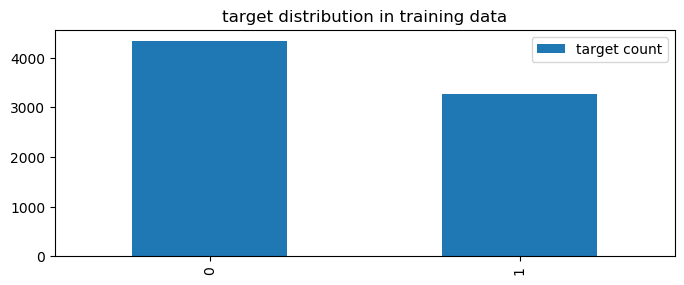

In [25]:
target_dist_training = plot_feature_col(twdata, 'target', 'target distribution in training data')

**there is no big gap between two different kind of taget types, will go with this as it is**

# Remove noise from data
Here train & test data both consists of lot of noise (stop words, delimeters, special symbols, lower case etc.) that need to be removed before we process the data further.

In [26]:
def _to_lower(datax, col):
    """ convert to lower case """
    datax['text'] = datax[col].apply(lambda x: x.lower())


In [27]:
_to_lower(twdata, 'text')
twdata.head(2)

,id,text,target
0,1,our deeds are the reason of this #earthquake may allah forgive us all nan,1
1,4,forest fire near la ronge sask. canada nan,1


In [28]:
# load spacy for few other cleaning
nlp = spacy.load('en_core_web_sm')

In [29]:
# tokenize 
twdata['clean_text']=twdata['text'].apply(lambda x: list(nlp(x)))

In [30]:
twdata.head(2)

,id,text,target,clean_text
0,1,our deeds are the reason of this #earthquake may allah forgive us all nan,1,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all, nan]"
1,4,forest fire near la ronge sask. canada nan,1,"[forest, fire, near, la, ronge, sask, ., canada, nan]"


In [31]:
def spacy_clean(data, col):
    # remove punctuations 
    data[col] = data[col].apply(lambda x: [t for t in x if (t.is_punct == False)])
    
    # remove stopwords
    data[col] = data[col].apply(lambda x: [t for t in x if (t.is_stop == False)])
    
    # remove digits
    data[col] = data[col].apply(lambda x: [t for t in x if (t.is_digit == False)])
    
    # lemmatize (should be done at the end)
    data[col] = data[col].apply(lambda x: [t.lemma_ for t in x])
    
    # join it to get back the original sentence
    data[col] = data[col].apply(lambda x: " ".join(x))

In [32]:
spacy_clean(twdata, 'clean_text')

In [33]:
# check the cleaned data
twdata.head(5)

,id,text,target,clean_text
0,1,our deeds are the reason of this #earthquake may allah forgive us all nan,1,deed reason earthquake allah forgive nan
1,4,forest fire near la ronge sask. canada nan,1,forest fire near la ronge sask canada nan
2,5,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected nan,1,resident ask shelter place notify officer evacuation shelter place order expect nan
3,6,"13,000 people receive #wildfires evacuation orders in california nan",1,"13,000 people receive wildfire evacuation order california nan"
4,7,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school nan,1,get send photo ruby alaska smoke wildfire pour school nan


In [34]:
# this data still has http://, @..., so need to clean further
def clean_regex(data, col):
    # remove http://
    data[col]=data[col].apply(lambda x: re.sub(r'http\S+', '', x))
    # remove '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    data[col]=data[col].apply(lambda text: ''.join([x for x in text if x not in string.punctuation]))
    # remove non ascii
    data[col]=data[col].apply(lambda text: ''.join([x for x in text if ord(x) < 128]))


In [35]:
clean_regex(twdata, 'clean_text')

In [36]:
twdata.sample(5)

,id,text,target,clean_text
4795,6821,@sw_trains strange loud impact bang noises under train to epsom about to arrive #wimbledon loud%20bang,0,swtrains strange loud impact bang noise train epsom arrive wimbledon loud20bang
364,522,beyonce is my pick for http://t.co/nnmqlz91o9 fan army #beyhive http://t.co/o91f3cyy0r 78 army,0,beyonce pick fan army beyhive army
7017,10058,#breaking144 obama declares disaster for typhoon-devastated saipan: obama signs disaster declarat... http://t.co/m8ciks60bx #acenewsdesk typhoon,1,breaking144 obama declare disaster typhoon devastate saipan obama sign disaster declarat acenewsdesk typhoon
5789,8259,@evacide the ferguson riots worked. this of this the next time you say rioting doesn't change anything.\n\nthere fixed it for you. rioting,1,evacide ferguson riot work time rioting change \n\n fix rioting
3784,5375,former township fire truck being used in philippines - langley times http://t.co/l90dcpv9zu #philippines fire%20truck,1,township fire truck philippines langley times philippines fire20truck


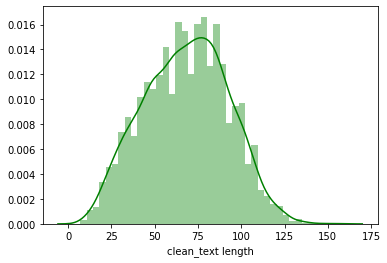

In [37]:
# check the clean text length distribution
clean_text_length=[len(x) for x in twdata['clean_text']] 
sb.distplot(clean_text_length, axlabel='clean_text length', color="g")

In [38]:
twdata.shape

(7613, 4)

In [39]:
# because of text cleaning few clean_text fields are zero length.
zl_idx=[idx for idx in range(len(clean_text_length)) if clean_text_length[idx]==0]
# drop this rows
twdata.drop(axis=0, inplace=True, index=zl_idx)

In [40]:
twdata.shape

(7613, 4)

In [41]:
twdata.to_csv('train_clean.csv')

In [42]:
# check the frequency of the words
twdata = pd.read_csv('train_clean.csv')

In [43]:
twdata.head()

,Unnamed: 0,id,text,target,clean_text
0,0,1,our deeds are the reason of this #earthquake may allah forgive us all nan,1,deed reason earthquake allah forgive nan
1,1,4,forest fire near la ronge sask. canada nan,1,forest fire near la ronge sask canada nan
2,2,5,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected nan,1,resident ask shelter place notify officer evacuation shelter place order expect nan
3,3,6,"13,000 people receive #wildfires evacuation orders in california nan",1,13000 people receive wildfire evacuation order california nan
4,4,7,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school nan,1,get send photo ruby alaska smoke wildfire pour school nan


In [44]:
all_data=" ".join(twdata['clean_text'])

In [45]:
words=all_data.split()

In [46]:
#common_words = Counter(words).most_common(50)

In [47]:
#common_words

In [48]:
#for w in common_words:
#    x_word=w[0]
#    y_val=w[1]#


In [49]:
words[:10]

['deed',
 'reason',
 'earthquake',
 'allah',
 'forgive',
 'nan',
 'forest',
 'fire',
 'near',
 'la']

In [50]:
#wcommn=pd.DataFrame(columns=['word','count'], data=common_words)

In [51]:
#wcommn.head()

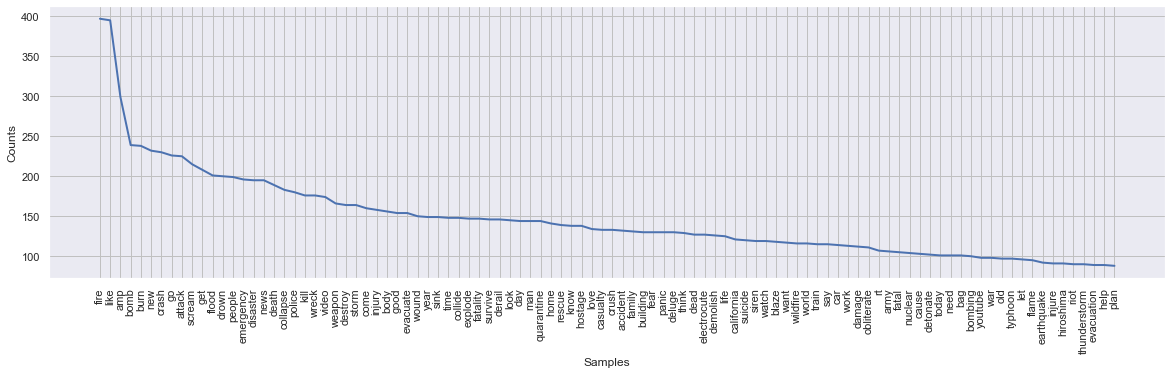

In [52]:
%matplotlib inline
sb.set(rc={'figure.figsize':(20,5)})

nltk_plot=nltk.FreqDist(words)
nltk_plot.plot(100)

In [53]:
# rt & nan is still there
def clean_regex_next(data, col):
    # remove rt
    data[col]=data[col].apply(lambda x: re.sub(r'rt', '', x))
    # remove nan
    data[col]=data[col].apply(lambda x: re.sub(r'nan', '', x))
    # remove digits
    data[col]=data[col].apply(lambda x: "".join(t for t in x if not t.isdigit()))
   

In [54]:
clean_regex_next(twdata, 'clean_text')

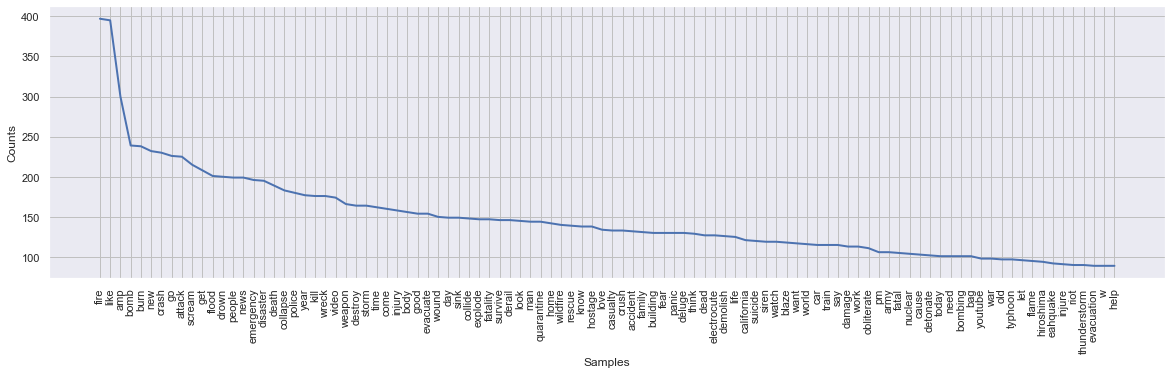

In [55]:
all_data=" ".join(twdata['clean_text'])
words=all_data.split()


sb.set(rc={'figure.figsize':(20,5)})

nltk_plot=nltk.FreqDist(words)
nltk_plot.plot(100)

** there are few single charecters, need to drop them.**

In [56]:
def drop_single_char(data, col):
    data[col]=data[col].apply(lambda x: x.split())
    data[col]=data[col].apply(lambda x: " ".join(t for t in x if len(t)>1))

In [58]:
drop_single_char(twdata, 'clean_text')

In [59]:
twdata.head()

,Unnamed: 0,id,text,target,clean_text
0,0,1,our deeds are the reason of this #earthquake may allah forgive us all nan,1,deed reason eahquake allah forgive
1,1,4,forest fire near la ronge sask. canada nan,1,forest fire near la ronge sask canada
2,2,5,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected nan,1,resident ask shelter place notify officer evacuation shelter place order expect
3,3,6,"13,000 people receive #wildfires evacuation orders in california nan",1,people receive wildfire evacuation order california
4,4,7,just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school nan,1,get send photo ruby alaska smoke wildfire pour school


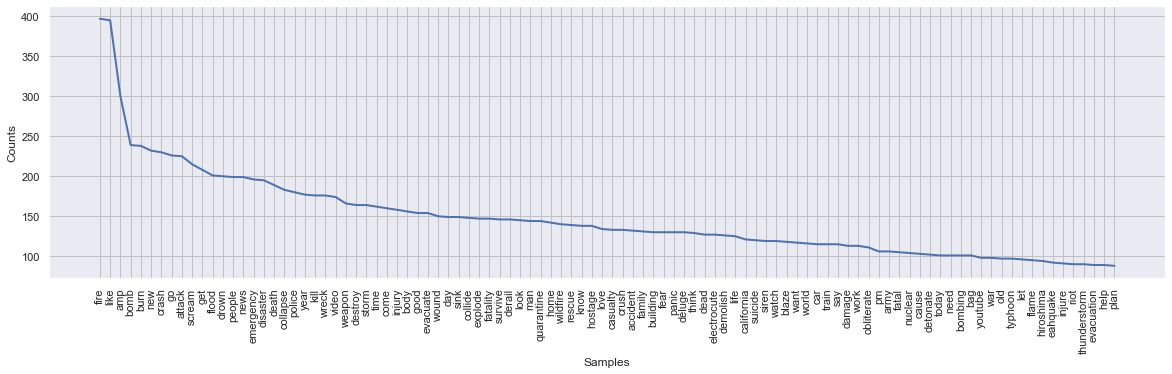

In [60]:
all_data=" ".join(twdata['clean_text'])
words=all_data.split()

sb.set(rc={'figure.figsize':(20,5)})

nltk_plot=nltk.FreqDist(words)
nltk_plot.plot(100)

** similar way clean the test data also **

In [61]:
_to_lower(testdata, 'text')

testdata['clean_text']=testdata['text'].apply(lambda x: list(nlp(x)))
spacy_clean(testdata, 'clean_text')

In [62]:
clean_regex(testdata, 'clean_text')

In [63]:
clean_regex_next(testdata, 'clean_text')
# there are few single charecters, need to drop them.
drop_single_char(testdata, 'clean_text')

In [64]:
testdata.head()

,id,text,clean_text
0,0,just happened a terrible car crash nan,happen terrible car crash
1,2,"heard about #earthquake is different cities, stay safe everyone. nan",hear eahquake different city stay safe
2,3,"there is a forest fire at spot pond, geese are fleeing across the street, i cannot save them all nan",forest fire spot pond geese flee street save
3,9,apocalypse lighting. #spokane #wildfires nan,apocalypse lighting spokane wildfire
4,11,typhoon soudelor kills 28 in china and taiwan nan,typhoon soudelor kill china taiwan


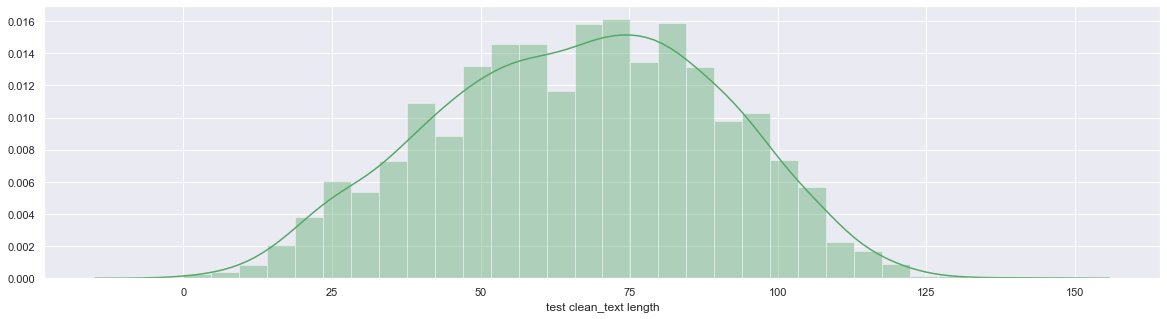

In [65]:
# check the clean text length distribution
clean_text_length=[len(x) for x in testdata['clean_text']] 
sb.distplot(clean_text_length, axlabel='test clean_text length', color="g")

In [66]:
# because of text cleaning few clean_text fields are zero length.
zl_idx=[idx for idx in range(len(clean_text_length)) if clean_text_length[idx]==0]
# drop this rows
testdata.drop(axis=0, inplace=True, index=zl_idx)

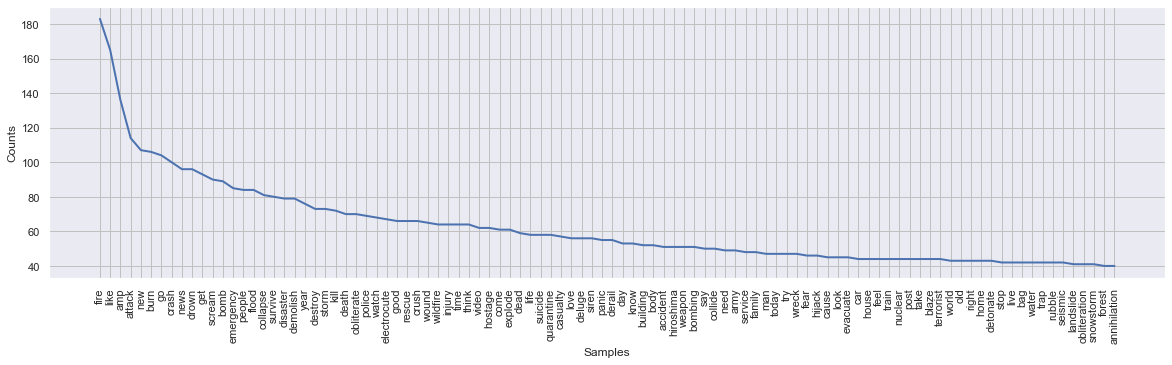

In [67]:
# plot the word frequency to understand the test data
all_data_test=" ".join(testdata['clean_text'])
words_test=all_data_test.split()

sb.set(rc={'figure.figsize':(20,5)})

nltk_plot=nltk.FreqDist(words_test)
nltk_plot.plot(100)

In [70]:
testdata.sample(5)

,id,text,clean_text
2882,9536,[august 06 2015 at 08:02pm] three israeli soldiers wounded in west bank terrorist attack via http://t.co/6ndherpbot terrorist,august pm israeli soldier wound west bank terrorist attack terrorist
2119,7096,inspectors so far denied access to iran's scientists - wall street journal http://t.co/sur3odwmka http://t.co/2vsx1yo5ht military,inspector far deny access iran scientist wall street journal military
524,1714,#sport - shane warne and ricky ponting shocked by australia batting collapse at trent bridge australian grea... http://t.co/c41iumknis bridge%20collapse,spo shane warne ricky ponting shock australia batting collapse trent bridge australian grea bridgecollapse
128,408,#askconnor there's a zombie apocalypse. the item to your right is your weapon. you're either screwed or you're gonna live. apocalypse,askconnor zombie apocalypse item right weapon screw go to live apocalypse
3167,10507,cherokee road and road 22 (three sisters wildfire): there are two roads closed to the general public: ... http://t.co/wwnl8fvfmm #idfire wildfire,cherokee road road sister wildfire road close general public idfire wildfire


# Create Model

**try **